In [1]:
#Loading required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

import warnings
from subprocess import check_output
from IPython.core.display import display, HTML
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 4)
warnings.simplefilter('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

In [2]:
#Reading the excel file in a dataframe
df = pd.read_csv("chocolate.csv",error_bad_lines=False,warn_bad_lines=True)

In [3]:
df.describe()

,REF,Review Date,Rating
count,1500.0000,1500.0000,1500.0000
mean,1036.8813,2012.3260,3.1832
std,554.6938,2.9337,0.4843
min,5.0000,2006.0000,1.0000
25%,572.0000,2010.0000,2.7500
50%,1071.0000,2013.0000,3.2500
75%,1503.0000,2015.0000,3.5000
max,1952.0000,2017.0000,5.0000


In [4]:
df.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Valrhona,Manjari,129,2007,64%,France,4.00,"Criollo, Trinitario",Madagascar
1,Original Beans (Felchlin),"Grand Cru Blend No.1, 5 yr. Anniversary Ed",1442,2014,80%,Switzerland,3.25,Blend,
2,Potomac,Upala w/ nibs,647,2011,70%,U.S.A.,3.50,Matina,Costa Rica
3,Middlebury,"Matagalpa, Cacao Bisiesto",1538,2015,70%,U.S.A.,3.50,,Nicaragua
4,Carlotta Chocolat,Cesar,1888,2016,65%,Colombia,3.50,CCN51,Colombia


In [5]:
df.rename(columns = {df.columns[0]:'Company',
                     'Specific Bean Origin\nor Bar Name':'SBO_BN',
                     'Review\nDate':'Review_Date',
                     'Cocoa\nPercent':'Cocoa_Percent',
                     'Company\nLocation':'Company_Location',
                     'Broad Bean\nOrigin':'BBO',
                     'Bean\nType':'Bean_Type'
                    },inplace=True)


In [6]:
df.columns

Index([u'Company', u'SBO_BN', u'REF', u'Review_Date', u'Cocoa_Percent',
       u'Company_Location', u'Rating', u'Bean_Type', u'BBO'],
      dtype='object')

df.head()

In [7]:
#Iterating over categorical columns to find how many unique values they have.
for column in df[['Company','SBO_BN','Review_Date','Company_Location','Bean_Type','BBO']]:
    print(df[column].value_counts().head(10))
    print("====================================")


Soma             39
Bonnat           23
Fresco           21
Pralus           20
A. Morin         19
Domori           19
Guittard         18
Arete            18
Coppeneur        17
Mast Brothers    17
Name: Company, dtype: int64
Madagascar            42
Peru                  37
Ecuador               37
Dominican Republic    33
Venezuela             18
Sambirano             17
Chuao                 16
Ocumare               15
Papua New Guinea      14
Ghana                 12
Name: SBO_BN, dtype: int64
2015    238
2014    212
2016    180
2012    156
2013    151
2011    137
2009    108
2010     95
2008     76
2007     64
Name: Review_Date, dtype: int64
U.S.A.         632
France         124
Canada         108
U.K.            79
Italy           59
Ecuador         47
Australia       46
Belgium         33
Switzerland     29
Germany         27
Name: Company_Location, dtype: int64
                        750
Trinitario              342
Criollo                 128
Forastero                67
Fora

In [8]:
df.describe(include='all')

,Company,SBO_BN,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,BBO
count,1500,1500,1500.0000,1500.0000,1500,1500,1500.0000,1499,1499
unique,391,893,NaN,NaN,45,57,NaN,36,93
top,Soma,Madagascar,NaN,NaN,70%,U.S.A.,NaN,,Venezuela
freq,39,42,NaN,NaN,568,632,NaN,750,174
mean,NaN,NaN,1036.8813,2012.3260,NaN,NaN,3.1832,NaN,NaN
std,NaN,NaN,554.6938,2.9337,NaN,NaN,0.4843,NaN,NaN
min,NaN,NaN,5.0000,2006.0000,NaN,NaN,1.0000,NaN,NaN
25%,NaN,NaN,572.0000,2010.0000,NaN,NaN,2.7500,NaN,NaN
50%,NaN,NaN,1071.0000,2013.0000,NaN,NaN,3.2500,NaN,NaN
75%,NaN,NaN,1503.0000,2015.0000,NaN,NaN,3.5000,NaN,NaN


<h3>Data Cleaning</h3>

1. Removing Percentage from Cocoa_Percent

In [9]:
def remove_percentage(l):
    temp = l.split('%')
    return np.float32(temp[0])

df['Cocoa_Percent']= df['Cocoa_Percent'].apply(lambda l: remove_percentage(l))

df.Cocoa_Percent.head(3)

0    64.0
1    80.0
2    70.0
Name: Cocoa_Percent, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
Company             1500 non-null object
SBO_BN              1500 non-null object
REF                 1500 non-null int64
Review_Date         1500 non-null int64
Cocoa_Percent       1500 non-null float64
Company_Location    1500 non-null object
Rating              1500 non-null float64
Bean_Type           1499 non-null object
BBO                 1499 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 105.5+ KB


In [11]:
df[df['Bean_Type'].isnull()]

,Company,SBO_BN,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,BBO
177,Soma,"Three Amigos(Chuao, Wild Bolivia, D.R.)",676,2011,70.0,Canada,4.0,NaN,"Ven, Bolivia, D.R."


In [12]:
df[df['BBO'].isnull()]

,Company,SBO_BN,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,BBO
750,Mast Brothers,Madagascar,999,2012,72.0,U.S.A.,2.5,Trinitario,NaN


In [13]:
unspecified=df.Bean_Type.values[3]

def nan_conversion(n):
    if n == unspecified:
        return np.nan
    else:
        return n
    
for col in df.columns:
    if df[col].dtype == 'O':
        df[col]=df[col].apply(lambda n: nan_conversion(n))

In [14]:
df.isnull().sum()

Company               0
SBO_BN                0
REF                   0
Review_Date           0
Cocoa_Percent         0
Company_Location      0
Rating                0
Bean_Type           751
BBO                  62
dtype: int64

In [15]:
df.Rating.value_counts()

3.50    320
3.00    285
3.25    251
2.75    210
3.75    181
2.50    115
4.00     82
2.00     28
2.25     12
1.50      9
1.00      4
5.00      2
1.75      1
Name: Rating, dtype: int64

Count of Chocolate Bar Ratings


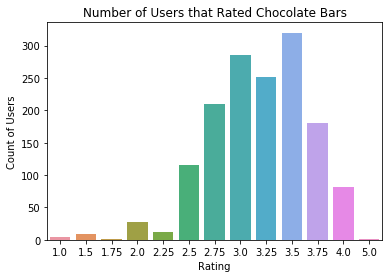

In [16]:
sns.countplot(x='Rating', data=df)
plt.xlabel('Rating')
plt.ylabel('Count of Users')
plt.title('Number of Users that Rated Chocolate Bars')
print('Count of Chocolate Bar Ratings')

Companies with the Highest Chocolate Vendors


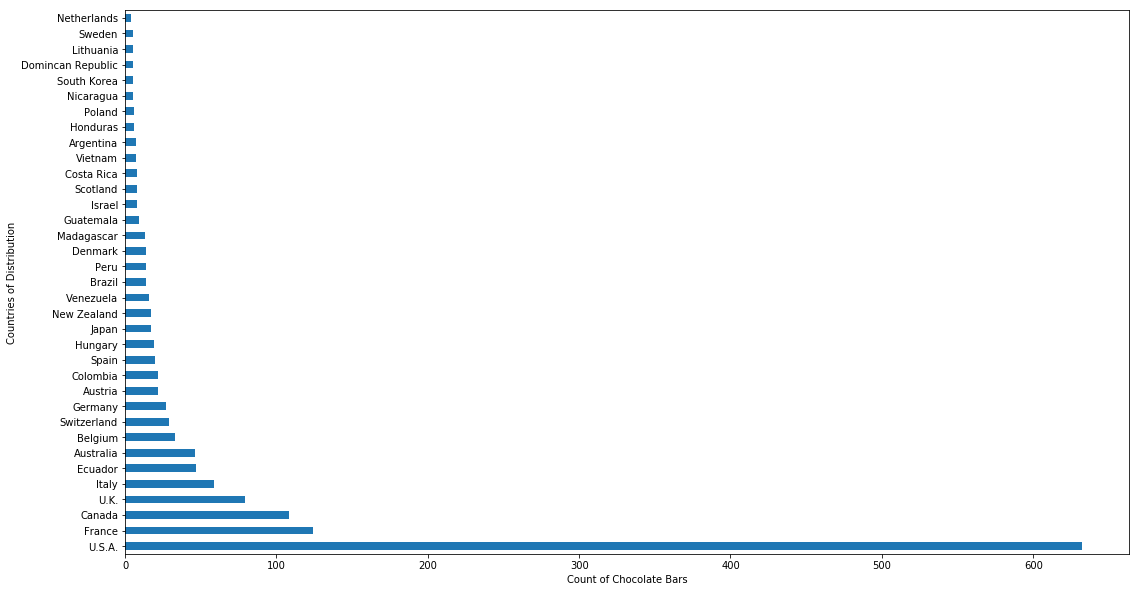

In [17]:
plt.rcParams['figure.figsize'] = (18,10)
df['Company_Location'].value_counts().head(35).plot('barh')
plt.xlabel('Count of Chocolate Bars')
plt.ylabel('Countries of Distribution')
print("Companies with the Highest Chocolate Vendors")

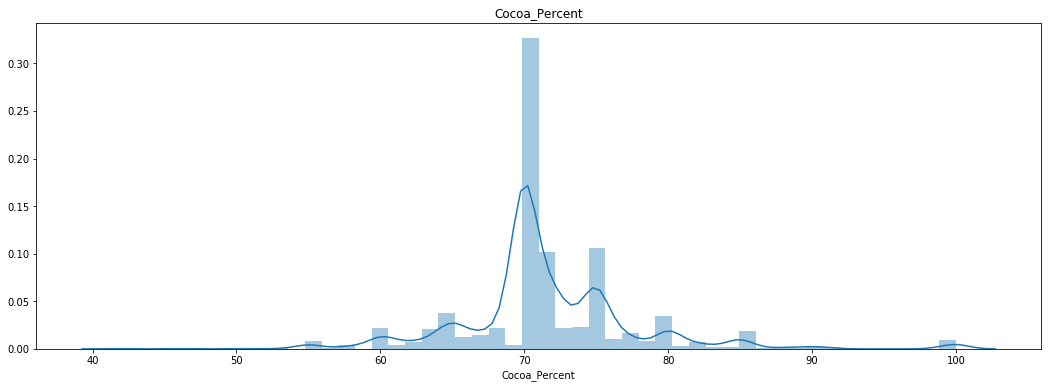

In [18]:
col = "Cocoa_Percent"
# set the plot figure size
plt.rcParams['figure.figsize'] = (18,6)
# Create box plot of degMalig and tumorSize
ax = sns.distplot(df[col])
# Set the title on graph
plt.title("Cocoa_Percent")
# Display Box plot
plt.show()

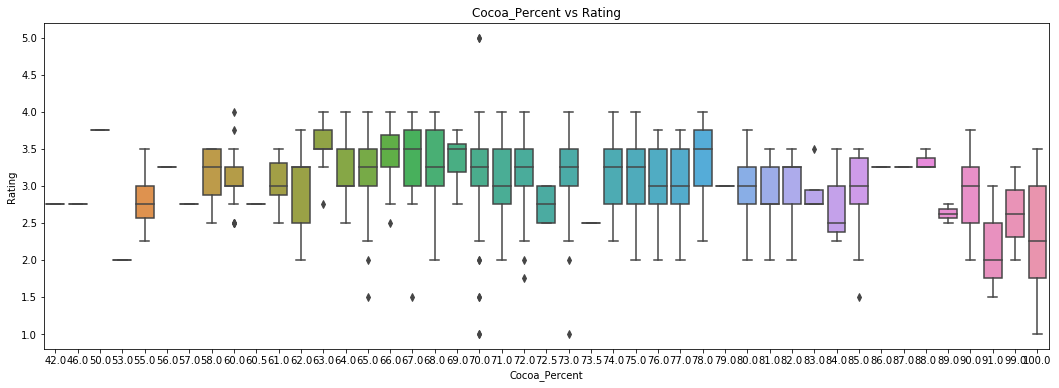

In [19]:

# set the plot figure size
plt.rcParams['figure.figsize'] = (18,6)
# Create box plot of degMalig and tumorSize
ax = sns.boxplot(x='Cocoa_Percent',y='Rating', data=df)
# Set the title on graph
plt.title("Cocoa_Percent vs Rating")
# Display Box plot
plt.show()

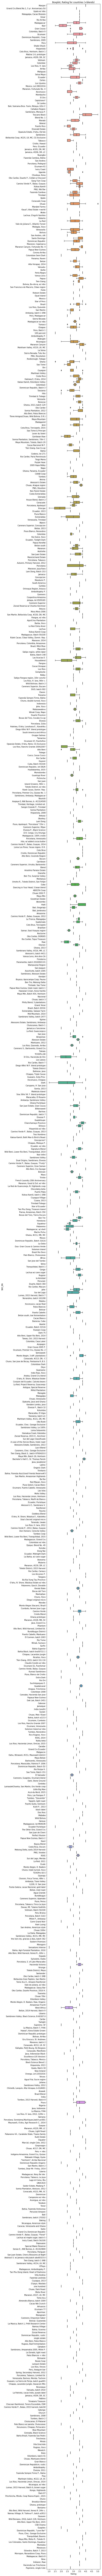

In [63]:
## Look at boxplot over the countries, even Blends
fig, ax = plt.subplots(figsize=[8, 200])
sns.boxplot(
    data=df,
    y='SBO_BN',
    x='Rating'
)
ax.set_title('Boxplot, Rating for countries (+blends)')
plt.tight_layout()

Text(0.5,1,'Boxplot, Rating for countries (+blends)')

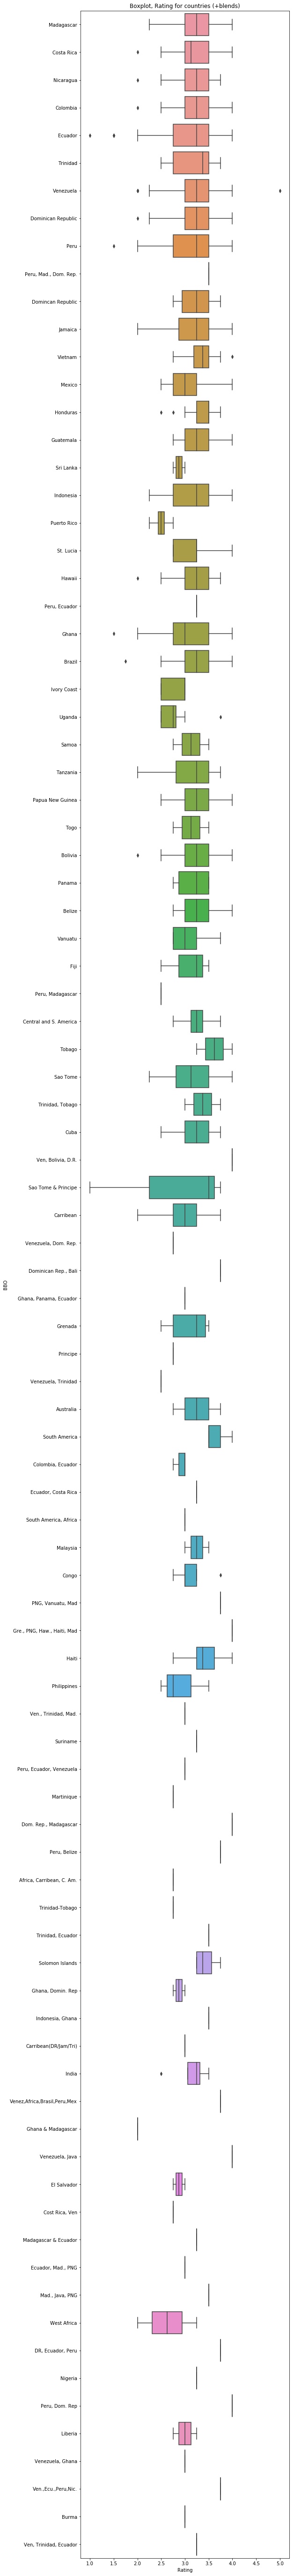

In [21]:
# Look at boxplot over the countries, even Blends
fig, ax = plt.subplots(figsize=[8, 100])
sns.boxplot(
    data=df,
    y='BBO',
    x='Rating'
)
ax.set_title('Boxplot, Rating for countries (+blends)')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
Company             1500 non-null object
SBO_BN              1500 non-null object
REF                 1500 non-null int64
Review_Date         1500 non-null int64
Cocoa_Percent       1500 non-null float64
Company_Location    1500 non-null object
Rating              1500 non-null float64
Bean_Type           749 non-null object
BBO                 1438 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 105.5+ KB


In [23]:


## Let's define blend feature
df['is_blend'] = np.where(np.logical_or(np.logical_or(df['SBO_BN'].str.lower().str.contains(',|(blend)|;'),df['BBO'].str.len() == 1),
        df['BBO'].str.lower().str.contains(',')), 1 , 0)

In [24]:
df['is_blend'].value_counts()

0    925
1    575
Name: is_blend, dtype: int64

In [25]:
df_ = df.drop('SBO_BN',axis=1)

In [26]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
Company             1500 non-null object
REF                 1500 non-null int64
Review_Date         1500 non-null int64
Cocoa_Percent       1500 non-null float64
Company_Location    1500 non-null object
Rating              1500 non-null float64
Bean_Type           749 non-null object
BBO                 1438 non-null object
is_blend            1500 non-null int32
dtypes: float64(2), int32(1), int64(2), object(4)
memory usage: 99.7+ KB


In [27]:

## Text preparation (correction) func
def txt_prep(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

In [28]:
df_['BBO'] = df_['BBO'].astype("|S")
df_['BBO'] = df_['BBO'].str.replace('.', '').apply(txt_prep)

In [29]:
df_['BBO'].unique()

array(['Madagascar', 'nan', 'Costa Rica', 'Nicaragua', 'Colombia',
       'Ecuador', 'Trinidad', 'Venezuela', 'Dominican Republic', 'Peru',
       'Peru,Madagascar,Dominican Republic', 'Jamaica', 'Vietnam',
       'Mexico', 'Honduras', 'Guatemala', 'Sri Lanka', 'Indonesia',
       'Puerto Rico', 'St Lucia', 'Hawaii', 'Peru,Ecuador', 'Ghana',
       'Brazil', 'Ivory Coast', 'Uganda', 'Samoa', 'Tanzania',
       'Papua New Guinea', 'Togo', 'Bolivia', 'Panama', 'Belize',
       'Vanuatu', 'Fiji', 'Peru,Madagascar', 'Central,South America',
       'Tobago', 'Sao Tome', 'Trinidad,Tobago', 'Cuba',
       'Venezuela,Bolivia,Dominican Republic', 'Sao Tome,Principe',
       'Carribean', 'Venezuela,Dominican Republic',
       'Dominican Republic,Bali', 'Ghana,Panama,Ecuador', 'Grenada',
       'Principe', 'Venezuela,Trinidad', 'Australia', 'South America',
       'Colombia,Ecuador', 'Ecuador,Costa Rica', 'South America,Africa',
       'Malaysia', 'Congo', 'Papua New Guinea,Vanuatu,Madagascar',
 

In [30]:
df_['Rating'] = (df_['Rating']* 100).astype(int)

In [31]:
cat_cols=['Company','Review_Date','Company_Location','Bean_Type','BBO']
dummies=pd.get_dummies(df_,columns=cat_cols,drop_first=True)

In [32]:
dummies.columns

Index([u'REF', u'Cocoa_Percent', u'Rating', u'is_blend', u'Company_AMMA',
       u'Company_Acalli', u'Company_Adi', u'Company_Aequare (Gianduja)',
       u'Company_Ah Cacao', u'Company_Akesson's (Pralus)',
       ...
       u'BBO_Venezuela,Dominican Republic',
       u'BBO_Venezuela,Ecuador,Peru,Nicaragua', u'BBO_Venezuela,Ghana',
       u'BBO_Venezuela,Java', u'BBO_Venezuela,Trinidad',
       u'BBO_Venezuela,Trinidad,Ecuador', u'BBO_Venezuela,Trinidad,Madagascar',
       u'BBO_Vietnam', u'BBO_West Africa', u'BBO_nan'],
      dtype='object', length=585)

In [33]:
def rating_to_stars(rating):
    
    rating = int(rating)
    
    if (rating == 0.0 ):
        return 0.0
    elif (rating > 0 ) and (rating <= 199 ):
        return 1.0
    elif (rating >= 200 ) and (rating <= 299 ):
        return 2.0
    elif (rating >= 300 ) and (rating <= 399 ):
        return 3.0
    else:
        return 4.0



In [34]:
dummies['Rating'] = dummies['Rating'].apply(rating_to_stars)

In [59]:
X= dummies.drop('Rating',axis=1)
y = dummies['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25, random_state=7)


('Accuracy Score :', 65.33333333333333)
('Training Accuracy :', 97.06666666666666)
('Testing Accuracy :', 65.33333333333333)
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.37      0.25      0.30        91
         3.0       0.72      0.85      0.78       259
         4.0       0.50      0.14      0.22        21

   micro avg       0.65      0.65      0.65       375
   macro avg       0.40      0.31      0.32       375
weighted avg       0.61      0.65      0.62       375



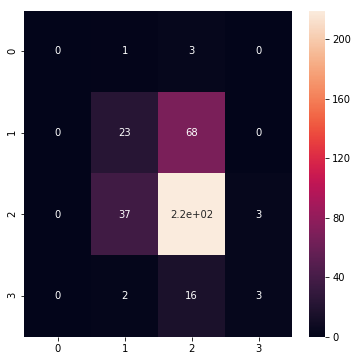

In [60]:
rating_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

rating_classifier.fit(X_train, y_train)

ModelPredictions = rating_classifier.predict(X_test)

print("Accuracy Score :",accuracy_score(y_true = y_test, y_pred = ModelPredictions)*100)

# evaluating the model
print("Training Accuracy :", rating_classifier.score(X_train, y_train)*100)
print("Testing Accuracy :", rating_classifier.score(X_test, y_test)*100)

# confusion matrix
cm = confusion_matrix(y_test, y_pred=ModelPredictions)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(y_test, y_pred=ModelPredictions)
print(cr)

('Accuracy Score :', 66.93333333333334)
('Training Accuracy :', 76.97777777777777)
('Testing Accuracy :', 66.93333333333334)
              precision    recall  f1-score   support

         1.0       1.00      0.25      0.40         4
         2.0       0.38      0.12      0.18        91
         3.0       0.70      0.92      0.79       259
         4.0       0.00      0.00      0.00        21

   micro avg       0.67      0.67      0.67       375
   macro avg       0.52      0.32      0.34       375
weighted avg       0.58      0.67      0.60       375



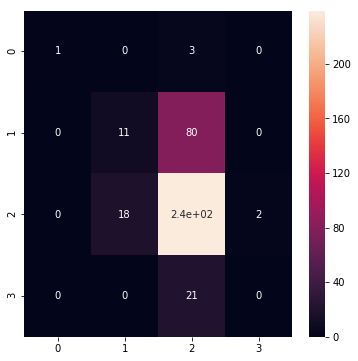

In [61]:
rating_classifier = LogisticRegression(random_state = 0)


rating_classifier.fit(X_train, y_train)

ModelPredictions = rating_classifier.predict(X_test)

print("Accuracy Score :",accuracy_score(y_true = y_test, y_pred = ModelPredictions)*100)

# evaluating the model
print("Training Accuracy :", rating_classifier.score(X_train, y_train)*100)
print("Testing Accuracy :", rating_classifier.score(X_test, y_test)*100)

# confusion matrix
cm = confusion_matrix(y_test, y_pred=ModelPredictions)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(y_test, y_pred=ModelPredictions)
print(cr)

('Accuracy Score :', 67.73333333333333)
('Training Accuracy :', 70.22222222222221)
('Testing Accuracy :', 67.73333333333333)
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.37      0.11      0.17        91
         3.0       0.70      0.94      0.80       259
         4.0       0.00      0.00      0.00        21

   micro avg       0.68      0.68      0.68       375
   macro avg       0.27      0.26      0.24       375
weighted avg       0.57      0.68      0.60       375



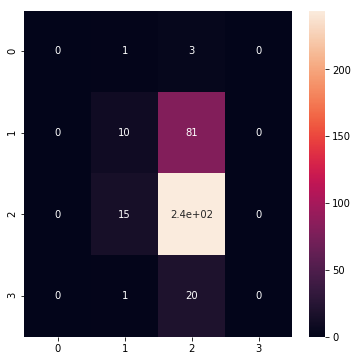

In [62]:
rating_classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)

rating_classifier.fit(X_train, y_train)

ModelPredictions = rating_classifier.predict(X_test)

print("Accuracy Score :",accuracy_score(y_true = y_test, y_pred = ModelPredictions)*100)

# evaluating the model
print("Training Accuracy :", rating_classifier.score(X_train, y_train)*100)
print("Testing Accuracy :", rating_classifier.score(X_test, y_test)*100)

# confusion matrix
cm = confusion_matrix(y_test, y_pred=ModelPredictions)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(y_test, y_pred=ModelPredictions)
print(cr)

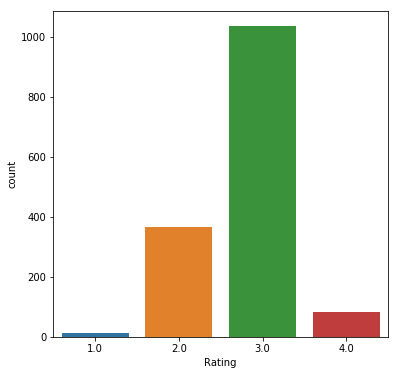

In [48]:
sns.countplot(x='Rating',data=dummies)

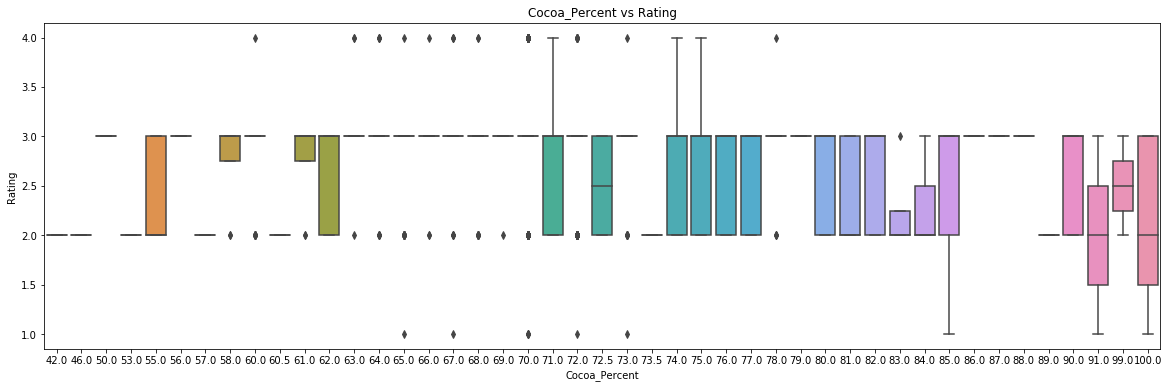

In [65]:
plt.rcParams['figure.figsize'] = (20,6)
# Create box plot of degMalig and tumorSize
ax = sns.boxplot(x='Cocoa_Percent',y='Rating', data=dummies)
# Set the title on graph
plt.title("Cocoa_Percent vs Rating")
# Display Box plot
plt.show()

In [89]:
b=df.query('Rating>=3.5').filter(items=['BBO'])

In [90]:
b.columns

Index([u'BBO'], dtype='object')

In [92]:
from imblearn.over_sampling import SMOTE 

In [93]:

X = dummies.drop('Rating',axis=1)                                                        #Feature Variables
y = dummies['Rating']                                                                    #Target Variable

sm = SMOTE(random_state=5687, ratio = 1.0)                                                    #Creating SMOTE variables
X_SMOTE, y_SMOTE = sm.fit_sample(X, y)                                                        #Resampling the dataset


X_train,X_test,y_train,y_test=train_test_split(X_SMOTE,y_SMOTE,test_size=0.30,random_state=0) #Splitting data in train-test



C:\Users\bajan\.conda\envs\py27\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


('Accuracy Score :', 69.74900924702774)
('Training Accuracy :', 74.6885617214043)
('Testing Accuracy :', 69.74900924702774)
              precision    recall  f1-score   support

         1.0       0.80      0.90      0.85       317
         2.0       0.19      0.09      0.12       101
         3.0       0.66      0.75      0.70       311
         4.0       0.00      0.00      0.00        28

   micro avg       0.70      0.70      0.70       757
   macro avg       0.41      0.44      0.42       757
weighted avg       0.63      0.70      0.66       757



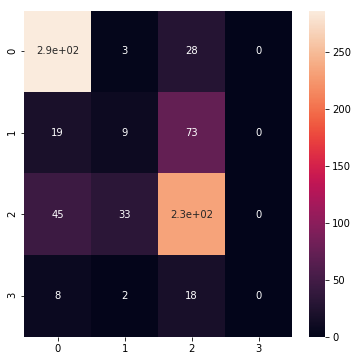

In [94]:
rating_classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)

rating_classifier.fit(X_train, y_train)

ModelPredictions = rating_classifier.predict(X_test)

print("Accuracy Score :",accuracy_score(y_true = y_test, y_pred = ModelPredictions)*100)

# evaluating the model
print("Training Accuracy :", rating_classifier.score(X_train, y_train)*100)
print("Testing Accuracy :", rating_classifier.score(X_test, y_test)*100)

# confusion matrix
cm = confusion_matrix(y_test, y_pred=ModelPredictions)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(y_test, y_pred=ModelPredictions)
print(cr)

('Accuracy Score :', 80.58124174372523)
('Training Accuracy :', 85.56058890147226)
('Testing Accuracy :', 80.58124174372523)
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       317
         2.0       0.36      0.12      0.18       101
         3.0       0.72      0.90      0.80       311
         4.0       0.00      0.00      0.00        28

   micro avg       0.81      0.81      0.81       757
   macro avg       0.51      0.51      0.49       757
weighted avg       0.74      0.81      0.76       757



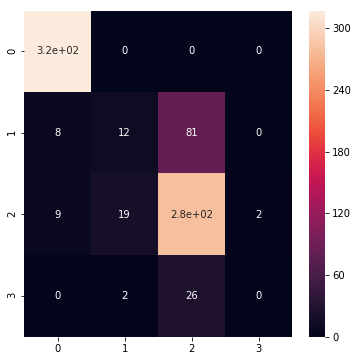

In [95]:
rating_classifier = LogisticRegression(random_state = 0)


rating_classifier.fit(X_train, y_train)

ModelPredictions = rating_classifier.predict(X_test)

print("Accuracy Score :",accuracy_score(y_true = y_test, y_pred = ModelPredictions)*100)

# evaluating the model
print("Training Accuracy :", rating_classifier.score(X_train, y_train)*100)
print("Testing Accuracy :", rating_classifier.score(X_test, y_test)*100)

# confusion matrix
cm = confusion_matrix(y_test, y_pred=ModelPredictions)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(y_test, y_pred=ModelPredictions)
print(cr)

('Accuracy Score :', 79.92073976221928)
('Training Accuracy :', 98.81087202718007)
('Testing Accuracy :', 79.92073976221928)
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       317
         2.0       0.35      0.23      0.28       101
         3.0       0.73      0.86      0.79       311
         4.0       0.12      0.04      0.06        28

   micro avg       0.80      0.80      0.80       757
   macro avg       0.55      0.53      0.53       757
weighted avg       0.77      0.80      0.78       757



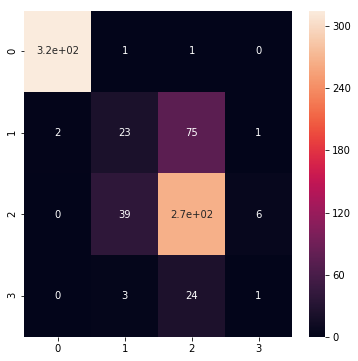

In [96]:
rating_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

rating_classifier.fit(X_train, y_train)

ModelPredictions = rating_classifier.predict(X_test)

print("Accuracy Score :",accuracy_score(y_true = y_test, y_pred = ModelPredictions)*100)

# evaluating the model
print("Training Accuracy :", rating_classifier.score(X_train, y_train)*100)
print("Testing Accuracy :", rating_classifier.score(X_test, y_test)*100)

# confusion matrix
cm = confusion_matrix(y_test, y_pred=ModelPredictions)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm ,annot = True)

# classification report
cr = classification_report(y_test, y_pred=ModelPredictions)
print(cr)